# Using Male Violent Decile Score to Predict Violent Recidivism

### This is all copied from the end of COMPAS Hypothesis Testing in section:
### "How Good is Decile Score at Predicting Recidivism (By Race)" 
### Look there for annotations, I'm doing the exact same thing with slightly different variables for violent recidivism, instead of general is_recid

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import SCORERS

import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)}) 
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [93]:
from mlxtend.regressor import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier

from xgboost import XGBRegressor, XGBClassifier


In [94]:
estimator_bagging  = BaggingClassifier(n_estimators=5, random_state=42) #  DTs
estimator_randomforest = RandomForestClassifier(n_estimators=5, random_state=42)
estimator_adaboost = AdaBoostClassifier(n_estimators=5, random_state=42)
estimator_bagging_10 = BaggingRegressor(n_estimators=10)
estimator_bagging_100 = BaggingRegressor(n_estimators=100)
estimator_randomforest = RandomForestRegressor(n_estimators=100)
estimator_bagging_elnet = BaggingRegressor(n_estimators=100, 
                                           base_estimator=ElasticNet())
estimator_bagging_random_tree = BaggingRegressor(n_estimators=100,
                                    base_estimator=ExtraTreeRegressor())
estimator_adaboost = AdaBoostRegressor(n_estimators=100)
estimator_xgboost = XGBRegressor(n_estimators=500)

In [95]:
compas = pd.read_csv("Compas.csv")

In [96]:
PredV = compas.drop(['Unnamed: 0', 'id', 'first', 'last', 'age', 'age_cat', 
       'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count',  "is_recid", 'decile_score',"score_text",
       'v_score_text', 'decile_score.1'], axis =1)

PredV = PredV[(PredV.is_violent_recid != -1)]
PredV = pd.get_dummies(PredV)
PredV = PredV.rename(columns ={'race_African-American':"race_African_American", 'race_Native American': "race_Native_American"})
PredV = PredV[(PredV.race_Caucasian == True) | (PredV.race_African_American == True)]
PredV = PredV.drop(['race_Asian','race_Caucasian', 'race_Hispanic', 'race_Native_American','race_Other'], axis =1)
PredV = PredV[PredV.sex_Female == 0].drop(["sex_Female", "sex_Male"], axis =1)

In [97]:
PredV

,is_violent_recid,v_decile_score,race_African_American
1,0,2,0
2,1,1,1
3,0,3,1
4,0,6,1
7,0,2,0
...,...,...,...
11748,0,5,0
11749,0,1,1
11751,0,1,1
11753,0,5,0


In [98]:
PredVBl= PredV[(PredV.race_African_American == True)]
PredVBl= PredVBl.drop("race_African_American", axis = 1)

In [99]:
targetvariable = "is_violent_recid"
independentvariables = PredVBl.drop(columns=[targetvariable]).columns

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

tree.fit(PredVBl[independentvariables], PredVBl[targetvariable])

VTreeAccuracyDecileScoreBlack = cross_val_score(tree, PredVBl[independentvariables],
                PredVBl[targetvariable], scoring="accuracy", 
                cv=3).mean()

In [100]:
def evaluate_modelBl(estimator):
    cv_results = cross_validate(estimator,
                    X = PredVBl[independentvariables],
                    y = PredVBl[targetvariable],
                    scoring="accuracy",
                          n_jobs=-1, cv=3,
                     return_train_score=True)
    return pd.DataFrame(cv_results).abs().mean().to_dict()

In [101]:
def display_results(results):
    results_df  = pd.DataFrame(results).T
    results_cols = results_df.columns
    for col in results_df:
        results_df[col] = results_df[col].apply(np.mean)
    return results_df

In [102]:
resultsVBl= {}

resultsVBl["Bagging"] = evaluate_modelBl(estimator_bagging)
resVBl= display_results(resultsVBl).iloc[[0][0]].test_score

In [103]:
PredVWh = PredV[(PredV.race_African_American == False)]
PredVWh = PredVWh.drop("race_African_American", axis = 1)

In [104]:
targetvariable = "is_violent_recid"
independentvariables = PredVWh.drop(columns=[targetvariable]).columns

tree.fit(PredVWh[independentvariables], PredVWh[targetvariable])

VTreeAccuracyDecileScoreWhite = cross_val_score(tree, PredVWh[independentvariables],
                PredVWh[targetvariable], scoring="accuracy", 
                cv=3).mean()

In [105]:
def evaluate_modelVWh(estimator):
    cv_results = cross_validate(estimator,
                    X = PredVWh[independentvariables],
                    y = PredVWh[targetvariable],
                    scoring="accuracy",
                          n_jobs=-1, cv=3,
                     return_train_score=True)
    return pd.DataFrame(cv_results).abs().mean().to_dict()

In [106]:
resultsVWh= {}

resultsVWh["Bagging"] = evaluate_modelVWh(estimator_bagging)
resVWh= display_results(resultsVWh).iloc[[0][0]].test_score
resVBl

0.8992975054302219

In [107]:
VBaggDiffAcc = round(abs(resVWh- resVBl) *100,2)

VTreeDiffAcc = round(abs(VTreeAccuracyDecileScoreWhite - VTreeAccuracyDecileScoreBlack) *100,2)

In [108]:
[VTreeAccuracyDecileScoreWhite,VTreeAccuracyDecileScoreBlack]

[0.9367982034007057, 0.8992975054302219]

In [109]:
print(f"According to Decision Tree, Decile Score for Black Criminals is {VTreeDiffAcc}% more accurate than Black Criminals")

According to Decision Tree, Decile Score for Black Criminals is 3.75% more accurate than Black Criminals


In [110]:
print(f"According to Decision Tree, Decile Score for Black Criminals is {VBaggDiffAcc}% more accurate than Black Criminals")

According to Decision Tree, Decile Score for Black Criminals is 3.75% more accurate than Black Criminals


In [111]:
VTreeresults = pd.DataFrame({"Race": ["Black Men", "White Men"],
                   'Accuracy': [VTreeAccuracyDecileScoreBlack, VTreeAccuracyDecileScoreWhite],
                   })
                   

In [112]:
VBaggresults = pd.DataFrame({"Race": ["Black Men", "White Men"],
                   'Accuracy': [resVBl, resVWh],
                   })

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Race'),
 Text(0.5, 1.0, ' Decile Score Accuracies By Race')]

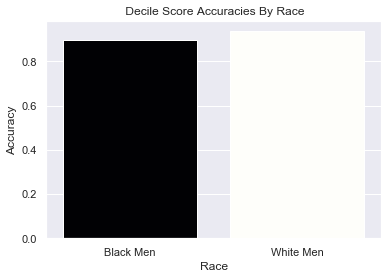

In [113]:
colors = [ "#000005","#FFFFF9" ]
customPalette = sns.set_palette(sns.color_palette(colors))
sns.set_palette(sns.color_palette(colors))

fig = sns.barplot(data = VTreeresults,x = "Race", y= "Accuracy", palette=customPalette)
fig.set(xlabel='Race', ylabel='Accuracy', Title = " Decile Score Accuracies By Race")

[Text(0, 0.5, 'Accuracy'),
 Text(0.5, 0, 'Race'),
 Text(0.5, 1.0, ' Decile Score Accuracies By Race')]

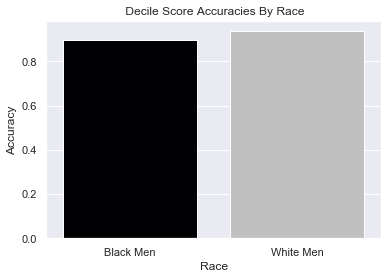

In [114]:
colors = [ "#000005","#C0C0C0" ]
customPalette = sns.set_palette(sns.color_palette(colors))
sns.set_palette(sns.color_palette(colors))

fig = sns.barplot(data = VBaggresults,x = "Race", y= "Accuracy", palette=customPalette)
fig.set(xlabel='Race', ylabel='Accuracy', Title = " Decile Score Accuracies By Race")